In [1]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import sentinnel_tools as st
import vector_tools as vt

# IMPORT, FLAG, AND CLEAN DATA

In [2]:
# Take RDI textfile and convert to xarray dataset
adcp1 = st.WinADCP_to_dataset('ADCP/ADCP01_all.txt')
adcp2 = st.WinADCP_to_dataset('ADCP/ADCP02_all.txt')

# Conduct quality assurance tests and flag data
adcp1 = st.adcp_qc(adcp1)
adcp2 = st.adcp_qc(adcp2)

#Add extra metadata to the datasets
adcp1.attrs['Description'] = 'First deployment of ADCP in Stillwater Cove'
adcp1.attrs['Latitude'] = 36.56194210195769
adcp1.attrs['Longitude'] = -121.94175918358738
adcp1.attrs['Instrument Height(m)'] = .44
adcp1.attrs['Creator'] = 'Logan Grady'
adcp1.attrs['Contact information'] = 'loganagrady@gmail.com'

adcp2.attrs['Description'] = 'Second deployment of ADCP in Stillwater Cove'
adcp2.attrs['Latitude'] = 36.56194989498659
adcp2.attrs['Longitude'] = -121.9417662787946
adcp2.attrs['Instrument Height(m)'] = .44
adcp2.attrs['Creator'] = 'Logan Grady'
adcp2.attrs['Contact information'] = 'loganagrady@gmail.com'

# Export the organized but raw data
adcp1.to_netcdf('ADCP/adcp1_raw2.nc')
adcp2.to_netcdf('ADCP/adcp2_raw2.nc')

Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Cannot conduct BIT test because variable does not exist in dataset


In [55]:
#Import raw datafiles
adcp1_raw = xr.open_dataset('ADCP/adcp1_raw.nc')
adcp2_raw = xr.open_dataset('ADCP/adcp2_raw.nc')

In [56]:
#Cut all profiles with mean flag values of 4, which are complete profile failures
adcp1_qc = adcp1_raw.where(adcp1_raw.Flag.mean(dim = "BinDist") != 4)#.dropna(dim = 'time', how = 'all')
#adcp2_qc = adcp2_raw.where(adcp2_raw.Flag.mean(dim = "BinDist") != 4)#.dropna(dim = 'time', how = 'all')

#NaN out all individual vector vales that flagged as 'fails'
adcp1_qc['East'] = adcp1_raw.East.where(adcp1_raw.Flag < 4)
adcp1_qc['North'] = adcp1_raw.North.where(adcp1_raw.Flag < 4)
adcp1_qc['Vertical'] = adcp1_raw.Vertical.where(adcp1_raw.Flag < 4)

#adcp2_raw['East'] = adcp2_qc.East.where(adcp2_qc.Flag <4)
#adcp2_raw['North'] = adcp2_qc.North.where(adcp2_qc.Flag <4)
#adcp2_raw['Vertical'] = adcp2_qc.Vertical.where(adcp2_qc.Flag <4)

In [57]:
#If there is still data that looks unusable or of bad quality, trim it
adcp1_qc = adcp1_qc.sel(time = slice('2022-07-22T00:00:00.000000000','2022-08-11T00:00:00.000000000')) #Keeps data within time slice
dropTimes = adcp1_qc.time.where(adcp1_qc.EA5.mean(dim = 'BinDist') > 139, drop=True).values
adcp1_qc = adcp1_qc.drop(dropTimes, dim='time')
#Deployment 2 appears to be okay, no extra trimming needed

(array([19196., 19198., 19200., 19202., 19204., 19205., 19207., 19209.,
        19211., 19213., 19215.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

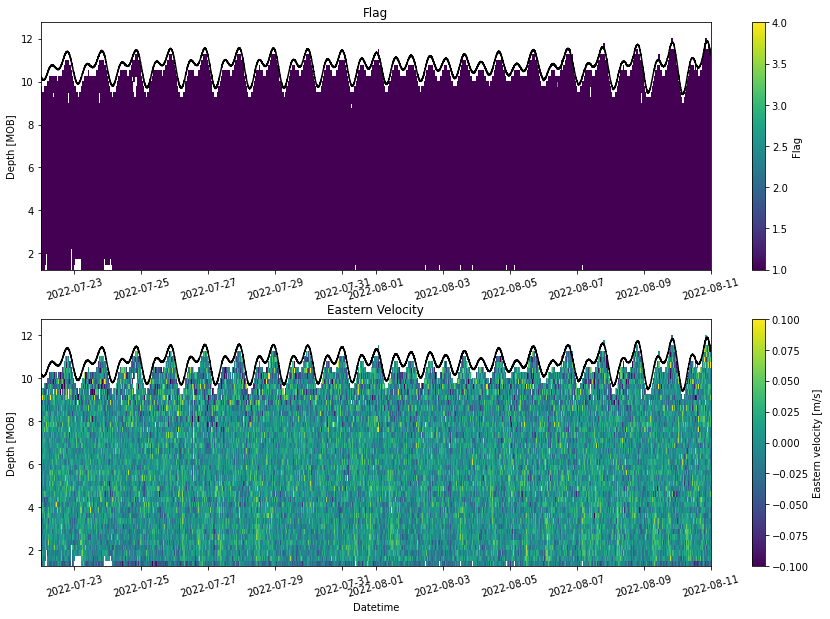

In [58]:
#Monitor full vector profile colorplots to check that remaining data is good quality

ds = adcp1_qc.copy(deep=True)
#ds = ds.sel(time = slice('2022-08-01T11:30:00.000000000','2022-08-01T12:30:00.000000000'))
depthOffset = ds.attrs['Instrument Height(m)']
min1 = 1 # Limits for the colorbars used on the adcp colorplots
max1 = 4
norm1 = matplotlib.colors.Normalize(vmin=min1,vmax=max1)

min2 = -.1
max2 = .1
norm2 = matplotlib.colors.Normalize(vmin=min2,vmax=max2)

plt.figure(figsize = (15,10))

plt.subplot(211)
plt.title('Flag')
plt.pcolormesh(ds.time, (ds.BinDist)+depthOffset, ds.Flag.where(ds.Flag.values < 4.).values,norm=norm1)
plt.plot(ds.time, ds.Depth+depthOffset, '-k')
plt.colorbar(label='Flag')
#plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xticks(rotation= 15)

plt.subplot(212)
plt.title('Eastern Velocity')
plt.pcolormesh(ds.time, (ds.BinDist)+depthOffset, ds.East.where(ds.Flag <= 4.),norm=norm2)
plt.plot(ds.time, ds.Depth+depthOffset, '-k')
plt.colorbar(label='Eastern velocity [m/s]')
#plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation= 15)

In [54]:
adcp1_raw.Flag.where(adcp1_raw.Flag < 4)

<xarray.DataArray 'Flag' (BinDist: 47, time: 34834)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-21T10:30:00 ... 2022-08-14T15:03:00
Dimensions without coordinates: BinDist
Attributes:
    Flag score:        [1, 2, 3, 4]
    Grade definition:  1 = Pass, 2 = Not evaluated, 3 = Suspect, 4 = Fail
    Description:       Flag grading system is based on QARTOD quality control...

In [53]:
ds.Flag.where(ds.Flag < 4)

<xarray.DataArray 'Flag' (BinDist: 47, time: 28775)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-22 2022-07-22T00:01:00 ... 2022-08-11
Dimensions without coordinates: BinDist
Attributes:
    Flag score:        [1, 2, 3, 4]
    Grade definition:  1 = Pass, 2 = Not evaluated, 3 = Suspect, 4 = Fail
    Description:       Flag grading system is based on QARTOD quality control...

In [52]:
ds.Flag

<xarray.DataArray 'Flag' (BinDist: 47, time: 28775)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.],
       [4., 4., 4., ..., 4., 4., 4.]])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-22 2022-07-22T00:01:00 ... 2022-08-11
Dimensions without coordinates: BinDist
Attributes:
    Flag score:        [1, 2, 3, 4]
    Grade definition:  1 = Pass, 2 = Not evaluated, 3 = Suspect, 4 = Fail
    Description:       Flag grading system is based on QARTOD quality control...

### Rotate vectors along principle axes

In [95]:
#Create depth averaged velocities for ENU vectors
adcp1_qc['EastDA'] = adcp1_qc.East.mean(dim = "BinDist")
adcp1_qc['NorthDA'] = adcp1_qc.North.mean(dim = "BinDist")
adcp1_qc['VerticalDA'] = adcp1_qc.Vertical.mean(dim = "BinDist")

adcp2_qc['EastDA'] = adcp2_qc.East.mean(dim = "BinDist")
adcp2_qc['NorthDA'] = adcp2_qc.North.mean(dim = "BinDist")
adcp2_qc['VerticalDA'] = adcp2_qc.Vertical.mean(dim = "BinDist")

#Find angle to rotate coordinate plane along primary and secondary principle axes
theta1, major1, minor1 = ts.princax(adcp1_qc.EastDA, adcp1_qc.NorthDA) # theta = angle, major = SD major axis (U), SD minor axis (V)
U1, V1 = ts.rot(adcp1_qc.EastDA, adcp1_qc.NorthDA, -theta1-90) #-theta - 90 rotates ensures the coordinate plane is rotated
                                                               #and not the vectors themselves

theta2, major2, minor2 = ts.princax(adcp2_qc.EastDA, adcp2_qc.NorthDA)
U2, V2 = ts.rot(adcp2_qc.EastDA, adcp2_qc.NorthDA, -theta2-90)

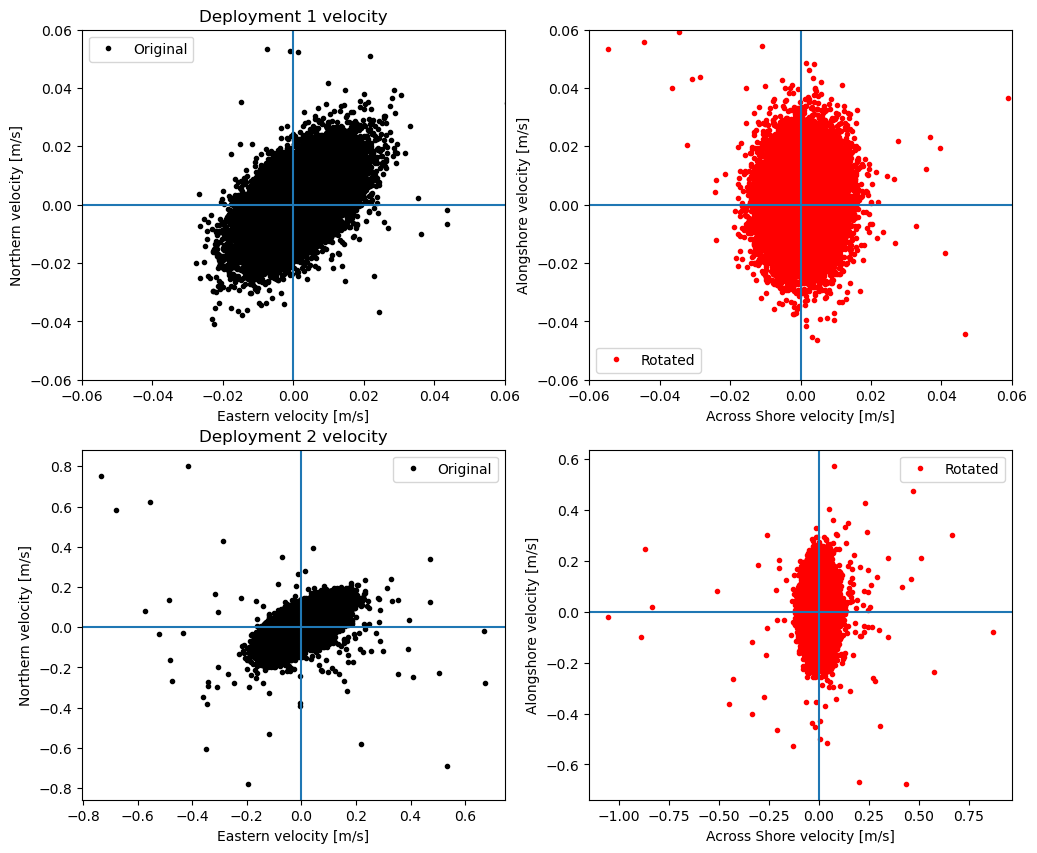

In [96]:
#Look at original vs. rotated vectors to visualize the priciple axes
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(adcp1_qc.EastDA, adcp1_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 1 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.xlim(-.06, .06)
plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(222)
plt.plot(-U1, -V1, '.r', label = 'Rotated')
plt.xlabel('Across Shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
plt.xlim(-.06, .06)
plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(223)
plt.plot(adcp2_qc.EastDA, adcp2_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 2 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
#plt.xlim(-.06, .06)
#plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(224)
plt.plot(-U2, -V2, '.r', label = 'Rotated')
plt.xlabel('Across Shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
#plt.xlim(-.06, .06)
#plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

Given the shape of coastline where mooring is located:
- Northeast/Southwest velocities have highest variance and correspond to alongshore direction of Arrowhead Point
- Northwest/Southeast velocity correspond more to acrossshore
- Positive alongshore indicates onshore current into SWC
- Positive across shore means onshore current towards Arrowhead Point

In [99]:
#Create rotated vector variables as alongshore and across shore
adcp1_qc['AlongshoreDA'] = (["time"], -V1) #Signs are flipped for velocities to correct the velocities 
adcp1_qc['AcrossShoreDA'] = (["time"], -U1) #into proper onshore (positive) and offshore (negative) values

adcp2_qc['AlongshoreDA'] = (["time"], -V2)
adcp2_qc['AcrossShoreDA'] = (["time"], -U2)

#Add the rotation angle to the attributes of the original adcp datasets
adcp1_qc.attrs['Rotation angle'] = -theta1-90
adcp2_qc.attrs['Rotation angle'] = -theta2-90

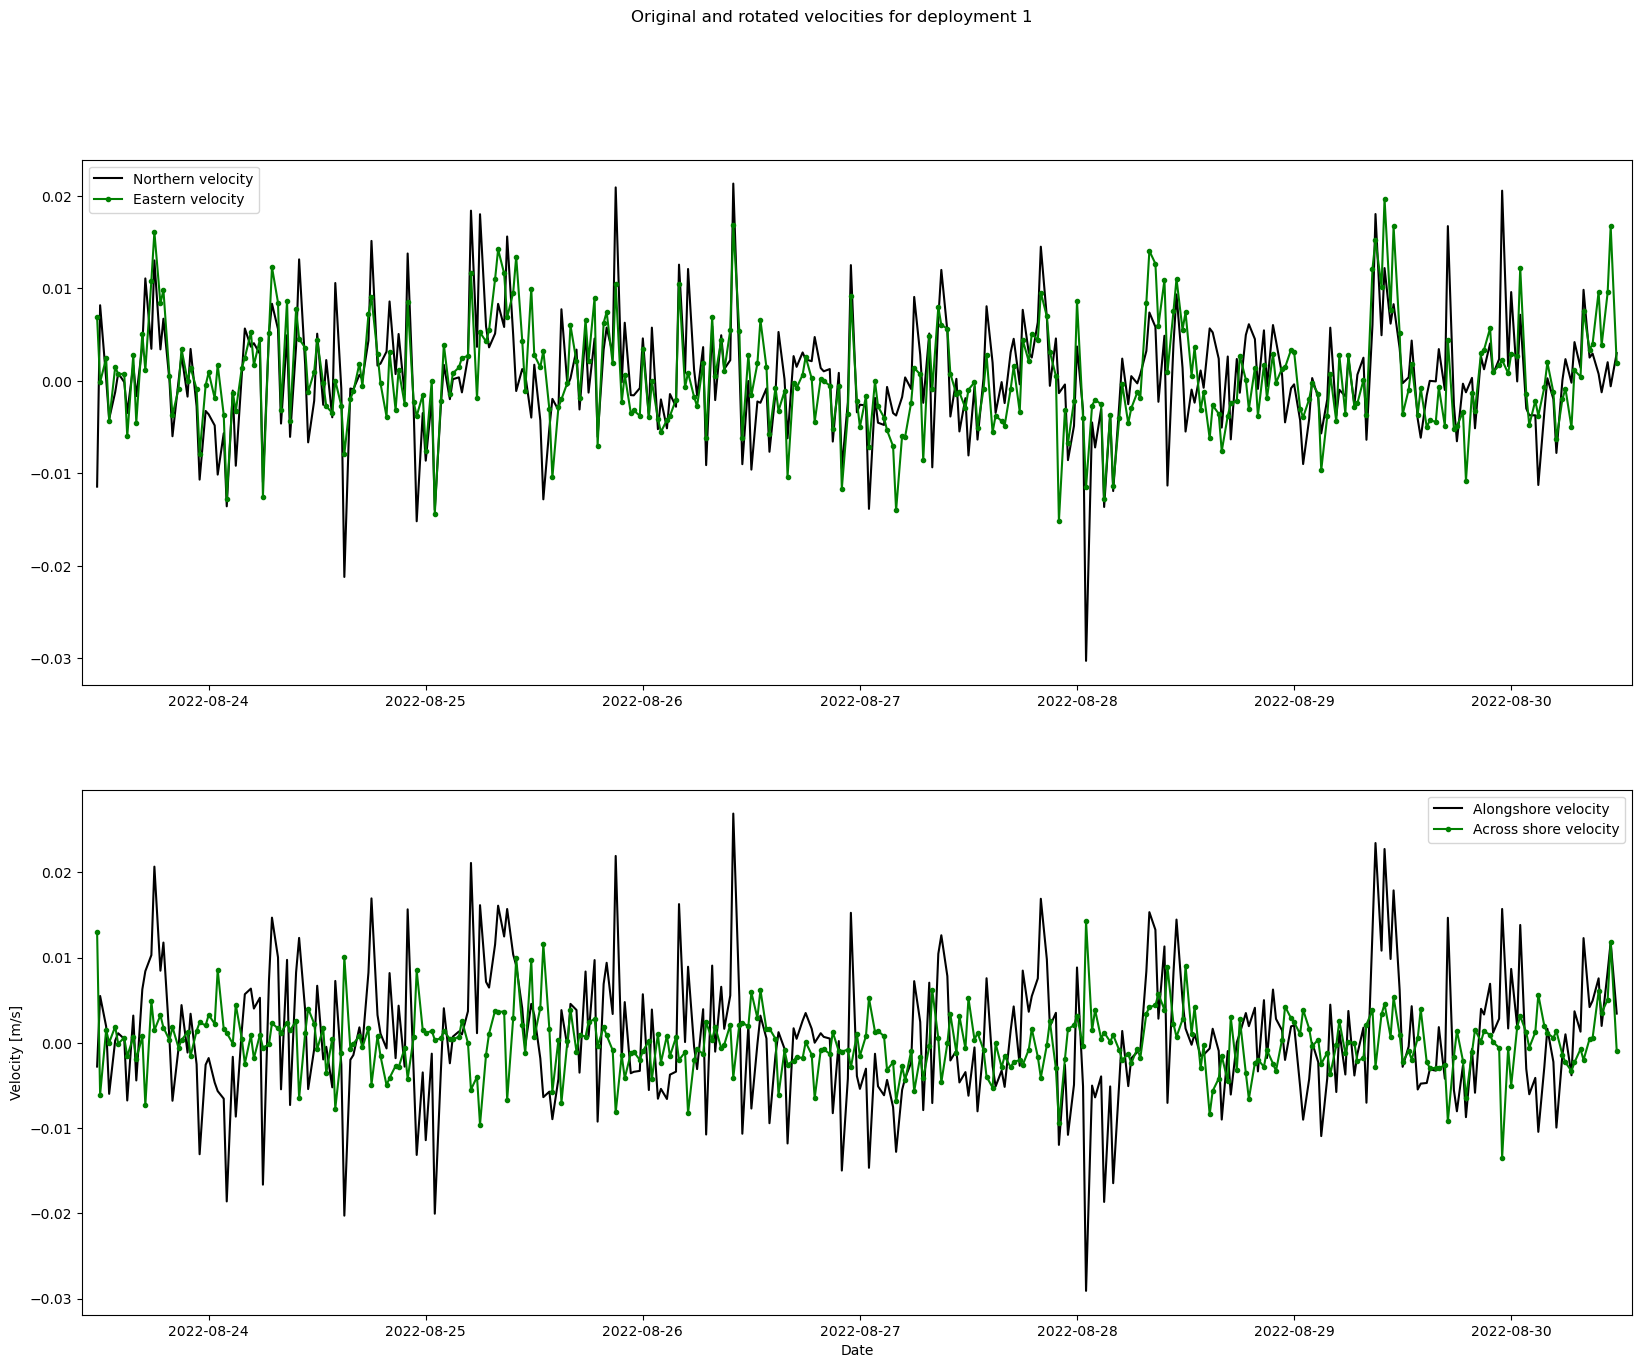

In [16]:
ds = adcp2_qc.copy(deep=True)

North = ds.NorthDA.resample(time='20Min').mean().dropna(dim='time')
East = ds.EastDA.resample(time='20Min').mean().dropna(dim='time')
Alongshore = ds.AlongshoreDA.resample(time='20Min').mean().dropna(dim='time')
AcrossShore = ds.AcrossShoreDA.resample(time='20Min').mean().dropna(dim='time')

plt.figure(figsize=(20,15))
plt.suptitle('Original and rotated velocities for deployment 1')

plt.subplot(211)
plt.plot(North.time, North, '-k', label = 'Northern velocity')
plt.plot(East.time, East, '.-g', label = 'Eastern velocity')
plt.margins(x=.01)
plt.legend()

plt.subplot(212)
plt.plot(Alongshore.time, Alongshore, '-k', label = 'Alongshore velocity')
plt.plot(AcrossShore.time, AcrossShore, '.-g', label = 'Across shore velocity')
plt.ylabel('Velocity [m/s]')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.margins(x=.01)
plt.legend()

In [100]:
#Export clean data to netcdf
adcp1_qc.to_netcdf('ADCP/adcp1_qc.nc')
adcp2_qc.to_netcdf('ADCP/adcp2_qc.nc')

In [3]:
#Import clean data
adcp1_qc = xr.open_dataset('ADCP/adcp1_final.nc')
adcp2_qc = xr.open_dataset('ADCP/adcp2_final.nc')

# BEAM COORDINATES
Have adcp velocities converted to beam coordinates for measuring reynolds stress from mode 12 data

In [ ]:
# Import the beam coordinate csv's
b1 = pd.read_csv('ADCP/SWC2_000_1_export.csv')
b2 = pd.read_csv('ADCP/SWC2_000_2_export.csv')
b3 = pd.read_csv('ADCP/SWC2_000_3_export.csv')
b4 = pd.read_csv('ADCP/SWC2_000_4_export.csv')

In [ ]:
# Combine the csv's in chronological order
#data = b1.append(b2)
#data = data.append(b3)
#data = data.append(b4)
#data = data.reset_index(drop=True)
#data = data.drop(columns=['index'])
#data.to_csv('ADCP/beam_data.csv', index=False)
data = pd.read_csv('ADCP/beam_data.csv')

In [ ]:
vel = data.filter(like='V')

In [ ]:
vel_B1 = vel.filter(like='B1')
vel_B2 = vel.filter(like='B2')
vel_B3 = vel.filter(like='B3')
vel_B4 = vel.filter(like='B4')

In [ ]:
time = pd.to_datetime(data.iloc[:,1])
dcell = range(1,48,1)

In [ ]:
B1_arr = vel_B1.to_numpy()
B2_arr = vel_B2.to_numpy()
B3_arr = vel_B3.to_numpy()
B4_arr = vel_B4.to_numpy()

In [ ]:
# create coords
rows = range(1,48,1) 
cols = time

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        B1=(["time", "dcell"], B1_arr),
        B2=(["time", "dcell"], B2_arr),
        B3=(["time", "dcell"], B3_arr),
        B4=(["time", "dcell"], B4_arr)
    ),
    coords=dict(
        dcell=(["dcell"], rows),
        time=(["time"], cols),
    ),
    attrs=dict(description="Velocity in beam coordinates"),
)

In [ ]:
ds['B1'].attrs['units'] = 'mm/s'
ds['B2'].attrs['units'] = 'mm/s'
ds['B3'].attrs['units'] = 'mm/s'
ds['B4'].attrs['units'] = 'mm/s'